In [1]:
import os
import numpy as np
import torch
from torch import nn
import my_nntools as nt
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import itertools
import time
import models as models
from utils import *


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
dataset_root_dir="./cezanne2photo/"

In [4]:
train_set = ImageDataset(dataset_root_dir, image_size=256, unaligned=True, mode='train')
test_set = ImageDataset(dataset_root_dir, image_size=256, unaligned=False, mode='test')

In [5]:
  
class C_GAN(NNClassifier):
    def __init__(self, fine_tuning=True):
        super(C_GAN, self).__init__()
        
        self.G_A2B = models.Generator(3, 3)
        self.G_B2A = models.Generator(3, 3)
        self.D_A = models.Discriminator(3)
        self.D_B = models.Discriminator(3)
        
        self.G_A2B.apply(init_parameters)
        self.G_A2B.apply(init_parameters)
        self.D_A.apply(init_parameters)
        self.D_B.apply(init_parameters)
    
        self.fake_a_buffer = ReplayBuffer()
        self.fake_b_buffer = ReplayBuffer()
    
    def forward(self, real_a, real_b):        
        fake_b = self.G_A2B(real_a)
        fake_a = self.G_B2A(real_b)
        return fake_a,fake_b


In [6]:
def plot(exp, fig, axes, A, B, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        fake_a,fake_b = exp.net(A[np.newaxis].to(exp.net.device),B[np.newaxis].to(exp.net.device))
    
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(A, ax=axes[0][0])
    axes[0][0].set_title('real A')
    
    myimshow(fake_b[0], ax=axes[0][1])
    axes[0][1].set_title('fake B')
    
    myimshow(B, ax=axes[1][0])
    axes[1][0].set_title('real B')
    
    myimshow(fake_a[0], ax=axes[1][1])
    axes[1][1].set_title('fake A')
    
    plt.tight_layout()
    fig.canvas.draw()

In [7]:

def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [8]:
def GetResults(net,test_set,cnt,dir_):
    test_loader = td.DataLoader(test_set, batch_size=4, shuffle=False, drop_last=True, pin_memory=True)
    net.eval()
    
    # Create output dirs if they don't exist
    if not os.path.exists('output_final/{}/A2B'.format(dir_)):
        os.makedirs('output_final/{}/A2B'.format(dir_))
    if not os.path.exists('output_final/{}/B'.format(dir_)):
        os.makedirs('output_final/{}/B'.format(dir_))
    if not os.path.exists('output_final/{}/B2A'.format(dir_)):
        os.makedirs('output_final/{}/B2A'.format(dir_))
    if not os.path.exists('output_final/{}/A'.format(dir_)):
        os.makedirs('output_final/{}/A'.format(dir_))
        
        
    with torch.no_grad():
        i=0
        for real_a,real_b in test_loader:
            real_a, real_b = real_a.to(net.device), real_b.to(net.device)
            fake_a,fake_b = net(real_a, real_b)
            a2b2a,b2a2a  = net(fake_a,fake_b)
            # Save image files
            tv.utils.save_image(0.5*(a2b2a+1), 'output_final/%s/A2B/%04d.png' % (dir_,i+1))
            tv.utils.save_image(0.5*(real_b+1), 'output_final/%s/B/%04d.png' % (dir_, i+1))
            tv.utils.save_image(0.5*(b2a2a+1), 'output_final/%s/B2A/%04d.png' % (dir_, i+1))
            tv.utils.save_image(0.5*(real_a+1), 'output_final/%s/A/%04d.png' % (dir_ , i+1))
            i+=1
            
            print('Generated images %04d of %04d' % (i, len(test_loader)))
            if(i == cnt):
                break



In [9]:
lr = 1e-3

net = C_GAN()
net = net.to(device)

optimizer_G = torch.optim.Adam(itertools.chain(net.G_A2B.parameters(), 
                                               net.G_B2A.parameters()), lr=lr)
optimizer_D_A = torch.optim.Adam(net.D_A.parameters(), lr=lr)
optimizer_D_B = torch.optim.Adam(net.D_B.parameters(), lr=lr)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

lr_scheduler = [lr_scheduler_G, lr_scheduler_D_A,lr_scheduler_D_B]
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, 
                     optimizer_G, optimizer_D_A,optimizer_D_B,lr_scheduler,stats_manager, output_dir="./model_weights/Cezanne/",batch_size=5)


Start/Continue training from epoch 200
Finish training for 200 epochs
duration 0.2038276195526123


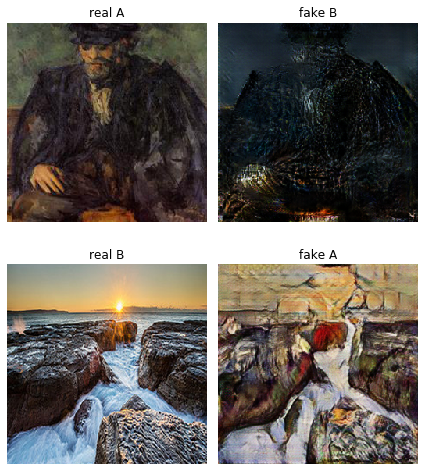

In [11]:

start_t = time.time()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6,7))
val_a,val_b=test_set[90]
exp1.run(200,lr_scheduler, plot=lambda exp: plot(exp, fig=fig, axes=axes, A=val_a, B=val_b))


print("duration",time.time()-start_t)


In [44]:
GetResults(net,test_set,5,"cezanne_test")

Generated images 0001 of 0187
Generated images 0002 of 0187
Generated images 0003 of 0187
Generated images 0004 of 0187
Generated images 0005 of 0187
